In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import expipe
import exdir
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import data_processing as dp

In [3]:
# change matplotlib default figsize and fonts
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
# get actions
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions
# actions
list(actions.keys())

['sarah-011-120321-2', 'maria-001-280721-1']

In [5]:
# remove leading and trailing recording data
t_start = 0
t_stop = None # None => don't remove anything

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

In [6]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=None,
)

In [7]:
action_id = "maria-001-280721-1" #choose an action
# common values for all units == faster calculations
x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
# a, at = map(data_loader.head_direction(action_id).get, ['a', 't'])

In [8]:
# number of tetrodes. this project (ca2mec) has two microdrives, each with 4 tetrodes
# Hence channel_grps will be equivalent to range(8)
channel_grps = dp.get_channel_groups(data_loader.data_path(action_id)) # number of tetrodes

# Find channels with units
channel_grps_with_units = {}
for channel_grp in channel_grps:
    spike_trains = data_loader.spike_trains(action_id, channel_grp)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_grp))
        continue
    else:
        channel_grps_with_units[channel_grp] = spike_trains

No spikes in channel group 6
No spikes in channel group 7


In [9]:
def partial_ratemap(*args, **kwargs):
    # not a general function - uses global vars etc
    (x,y),t,spike_times = dp.data_scope(*args, **kwargs)
    spatial_map = sp.SpatialMap(x,y,t,spike_times, box_size=box_size, bin_size=bin_size) # global vars
    ratemap = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=True) # global vars
    ratemap = np.rot90(ratemap)
    return ratemap

In [10]:
# Calculate partial (part of a trial) ratemaps for all cells
ratemaps = {}
for channel_grp, spike_trains in channel_grps_with_units.items():
    for unit_id, spike_times in spike_trains.items():
        
        # split trial in two on the middle for every unit.
        ratemaps[unit_id] = [partial_ratemap([x,y], t, spike_times, scope=np.array([0.0, 0.5])), \
                             partial_ratemap([x,y], t, spike_times, scope=np.array([0.5, 1.0]))]

In [11]:
def cross_correlation_distance(correlation):
    labels = sp.separate_fields_by_laplace(correlation, threshold=0)
    peaks = sp.calculate_field_centers(correlation, labels)
    centered_peaks = peaks - np.array(correlation.shape) / 2
    offset = np.linalg.norm(centered_peaks, axis=1)
    distance_idx = np.argmin(offset)
    distance = offset[distance_idx]
    angle = np.arctan2(*centered_peaks[distance_idx])
    return distance, angle

def cross_correlation_centre_of_mass(correlation):
    from scipy import ndimage
    cntr = ndimage.center_of_mass(correlation)
    center = np.array(correlation.shape) / 2
    centered_cntr = cntr - center
    distance = np.linalg.norm(centered_cntr)
    angle = np.arctan2(*centered_cntr)
    return center, centered_cntr, distance, angle

def peak_shift(correlation):
    # find all peaks
    labels = sp.separate_fields_by_laplace(correlation, threshold=0)
    peaks = sp.calculate_field_centers(correlation, labels) #, center_method='center_of_mass')
    
    # calculate coordinates of peaks relative to 'image'-center
    center = np.array(correlation.shape) / 2
    if len(peaks) == 0:
        # no peaks
        return center, None, None, None
    centered_peaks = peaks - center
    
    # find closest peak
    offset = np.linalg.norm(centered_peaks, axis=1)
    distance_idx = np.argmin(offset)
    
    # also find distance, angle representation
    distance = offset[distance_idx]
    angle = np.arctan2(*centered_peaks[distance_idx])
    return center, centered_peaks[distance_idx], distance, angle

def split_correlation(correlation):
    """
    split a matrix of positive and negative correlations into
    two separate positive and negative matrices.
    """
    pos_corr = np.zeros(corr.shape)
    neg_corr = np.zeros(corr.shape)
    pos_corr[corr >= 0] = corr[corr >= 0]
    neg_corr[corr < 0] = corr[corr < 0]
    return pos_corr, neg_corr

argmax2d = lambda x: np.unravel_index(np.argmax(x), x.shape)

[104, 199, 704, 377, 499, 690, 714, 95, 611, 653, 683, 692, 303, 329, 398, 639, 661, 668, 338, 238]


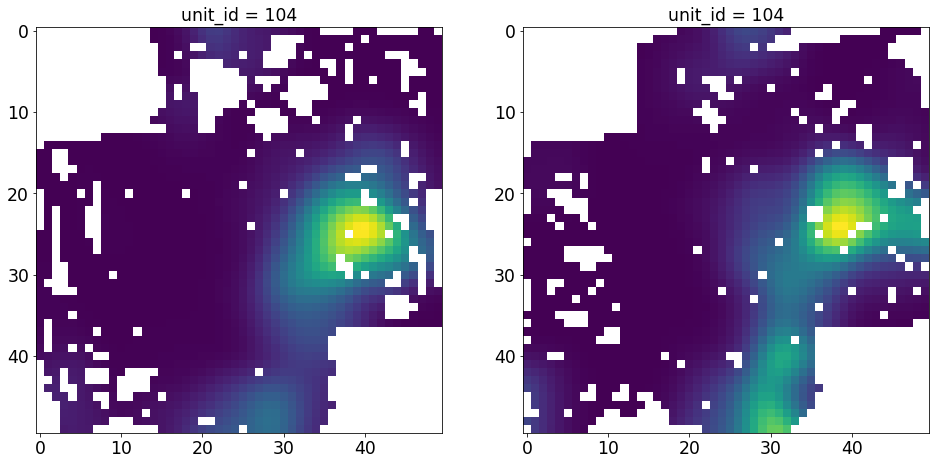

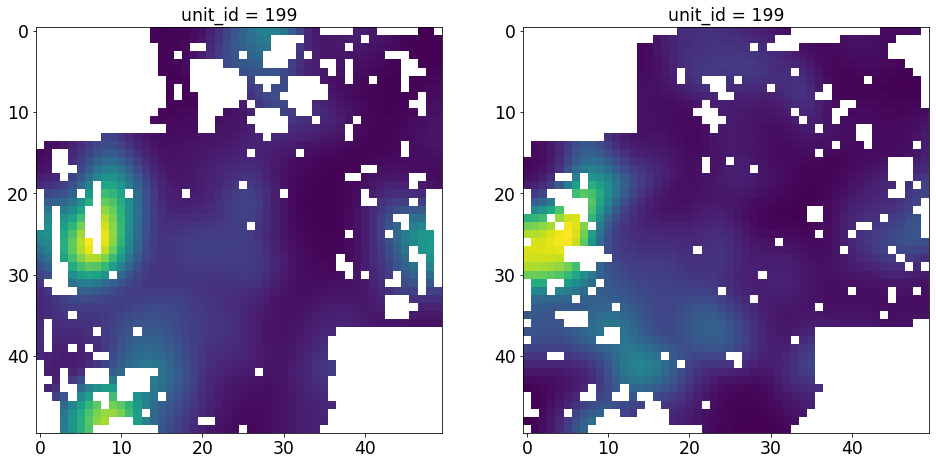

In [20]:
units = list(ratemaps.keys())
print(units)
subset = slice(0,2,1)
for unit in units[subset]:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(ratemaps[unit][0])
    axs[1].imshow(ratemaps[unit][1])
    [ax.set_title("unit_id = {}".format(unit)) for ax in axs]

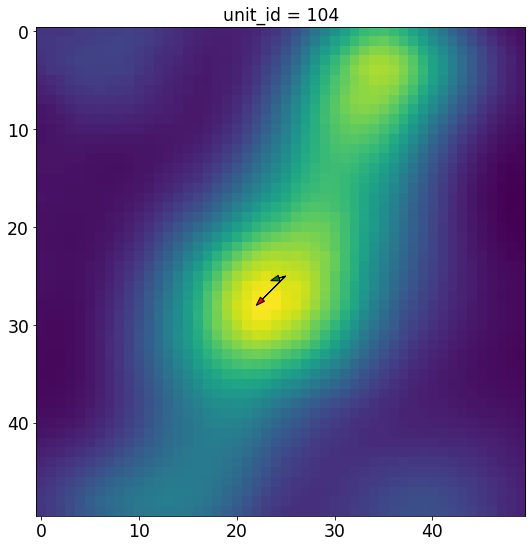

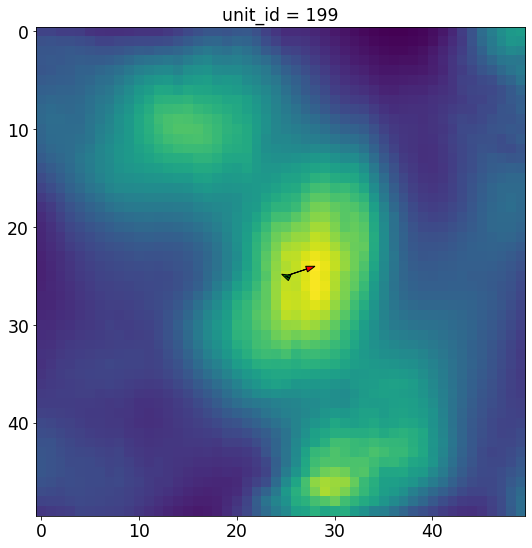

In [13]:
import scipy
for unit in units[subset]:
    # mode = 'frobenius'
    corr = sp.nancorrelate2d(*ratemaps[unit], mode='frobenius')
    fig, ax = plt.subplots()
    ax.imshow(corr)
    
    # closest (to center of img) mode (RED)
    center, dxdy = peak_shift(corr)[:2]
    if dxdy is not None:
        ax.arrow(*center, *dxdy, head_width=0.6, length_includes_head=True, facecolor='red')
        
    # center of mass / expected value (GREEN)
    center, dxdy, _, _ = cross_correlation_centre_of_mass(corr)
    ax.arrow(*center, *dxdy, head_width=0.6, length_includes_head=True, facecolor='green')
    ax.set_title("unit_id = {}".format(unit))

### Frobenius

In [14]:
# calculate all displacement vectors 
mode = 'frobenius'
displacement_vectors = {}
for unit in ratemaps.keys():
    corr = sp.nancorrelate2d(*ratemaps[unit], mode=mode)
    displacement_vectors[unit] = cross_correlation_centre_of_mass(corr)[1:]

LinregressResult(slope=0.5523493439801227, intercept=-0.21059305796551442, rvalue=0.40871506162522503, pvalue=0.07357845169857637, stderr=0.2907146615229668)


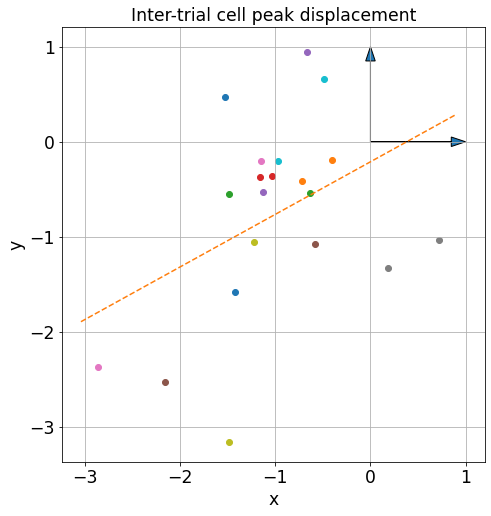

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
for v,_,_ in displacement_vectors.values():
    ax.scatter(*v)
    
vs = []
for v,_,_ in displacement_vectors.values():
    vs.append(v)
vs = np.array(vs).T
reg = scipy.stats.linregress(*vs)
plt.plot([0,])
print(reg)

x_vals = np.array(ax.get_xlim())
y_vals = reg.intercept + reg.slope * x_vals
ax.plot(x_vals, y_vals, '--')

ax.grid('on')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inter-trial cell peak displacement')
ax.set_aspect('equal')
# add cardinal axes
ax.arrow(0,0,0,1, head_width=0.1, length_includes_head=True)
ax.arrow(0,0,1,0, head_width=0.1, length_includes_head=True)

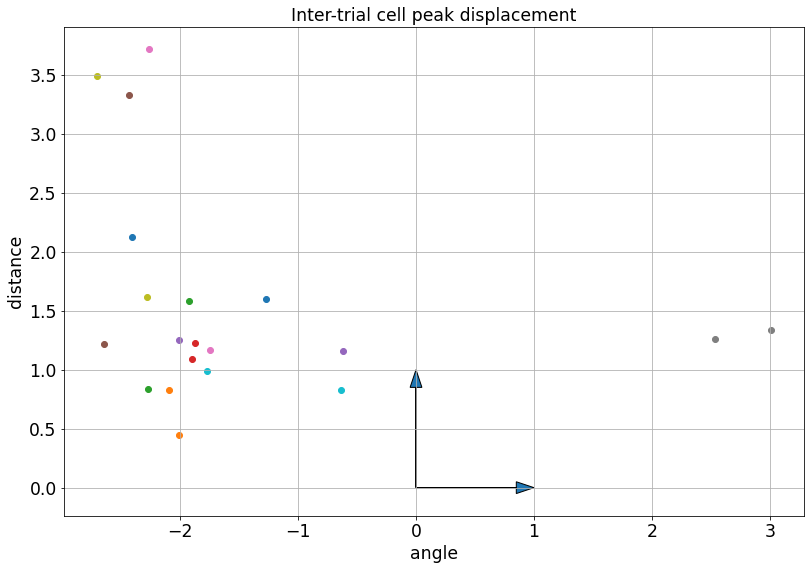

In [16]:
fig, ax = plt.subplots()
for _,d,a in displacement_vectors.values():
    ax.scatter(a,d) if d is not None else None
ax.grid('on')
ax.set_xlabel('angle')
ax.set_ylabel('distance')
ax.set_title('Inter-trial cell peak displacement')
ax.set_aspect('equal')
# add cardinal axes
ax.arrow(0,0,0,1, head_width=0.1, length_includes_head=True)
ax.arrow(0,0,1,0, head_width=0.1, length_includes_head=True)

In [17]:
def vector_histogram():
    """
    Histogram over displacement vectors, also include directional information.
    We want to know if the vectors have a directional prefrence (following the animal?).
    """
    return stuff

def dT(distances, angles, ax):
    """
    Plot angles and distances against each other in a scatter plot.
    Also 2dhistogram is a possibility
    
    Want to see spatial-cell-instability biased by socializing/novel object
    
    OBSOBS! angles are/should be circular
    """
    ax.scatter(angles, distances)
    return ax

def vector_plot(displacement_vectors, ax):
    """
    Plot angles and distances against each other in a scatter/quiver plot.
    Also 2dhistogram is a possibility
    
    Want to see spatial-cell-instability biased by socializing/novel object
    """
    ax.scatter(*displacement_vectors)
    return ax